In [40]:
# Jupyter commands used to auto-reload packages
%load_ext autoreload
%autoreload 2

# Import dependencies
import os
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit, OptimizeWarning

# Make plots larger
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
## loading required packages  

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
## loading the data
ifile = 'Production.csv'
df_prod = pd.read_csv(ifile)

In [44]:
df_prod.head()

,Well ID,DAYS,OIL,GAS,WATER
0,1,0,630.868000,1157.095194,66.671992
1,1,31,552.874349,1444.594307,33.964977
2,1,61,556.648235,1160.644566,0.000000
3,1,92,440.915721,1238.730745,0.000000
4,1,122,340.278752,1029.317811,0.000000


## First 8 wells

#### Two different models are trained, one for the first 8 wells with available month data and another for the last 4 wells with daily production data

In [45]:
## this function gets the historical data, ie, production data before one time step

def get_history(wid, n_months, phase): ## input desired well, months for hindcast and phase
    data=df_prod[['%s'%phase]].loc[df_prod['Well ID']==wid]   ##subsetting 
    data.reset_index(drop=True, inplace=True)
    hist=(df_prod['%s'%phase].loc[df_prod['Well ID']==wid]).shift(1, axis=0).values
    data['%s_hist'%phase]=hist
    data.dropna(inplace=True)
    train, test= data.iloc[:n_months-1,:], data.iloc[n_months-1,:]  ## train-test split
    return train, test

In [47]:
## sample
train, test=get_history(wid=6,n_months=18,phase='OIL')
train.head()

,OIL,OIL_hist
1,780.645161,37.900000
2,570.000000,780.645161
3,436.571429,570.000000
4,294.000000,436.571429
5,323.266667,294.000000


In [48]:
test

OIL          84.677419
OIL_hist    104.300000
Name: 18, dtype: float64

In [ ]:
## Using a random forest regressor to forecast oil, gas and water production for 6, 12 and 18 months from their historical 
## data for the forst 8 wells

well=[]
fluid_phase=[]
hind_rmse=[]

for n_months in [6,12,18]:
    error=[]
    for wid in range (1,9):
        for phase in ['OIL', 'GAS', 'WATER']:
            well.append(wid)
            fluid_phase.append(phase)
            train, test=get_history(wid=wid,n_months=n_months,phase=phase)
            trainx=train.values[:,1].reshape(len(train), 1)
            trainy=train.values[:,0].reshape(len(train), 1)
            testx=np.array(test.values[1]).reshape(1,1)
            testy=np.array(test.values[0]).reshape(1,1)
            rf=RandomForestRegressor(n_estimators=1000)
            rf.fit(trainx, trainy)
            yhat=rf.predict(testx)
            rmse=np.sqrt(np.mean((testy - yhat) ** 2))
            error.append(rmse)
    hind_rmse.append(error)
            
            

In [ ]:
## compiling the rmse for the different scenarios

df_rmse=pd.DataFrame()
df_rmse['Well ID']=well[0:24]
df_rmse['Phase']=fluid_phase[0:24]
df_rmse['hind_6_months_rmse']=hind_rmse[0]
df_rmse['hind_12_months_rmse']=hind_rmse[1]
df_rmse['hind_18_months_rmse']=hind_rmse[2]


In [51]:
df_rmse['Average_hind_rmse'] = df_rmse.iloc[:, 2:].mean(axis=1) ##getting avg rmse
df_rmse.head()

,Well ID,Phase,hind_6_months_rmse,hind_12_months_rmse,hind_18_months_rmse,Average_hind_rmse
0,1,OIL,75.076437,86.525150,20.533087,60.711558
1,1,GAS,100.787960,222.602399,80.254845,134.548401
2,1,WATER,0.000000,11.950640,16.696635,9.549092
3,2,OIL,55.177363,17.905833,1.649417,24.910871
4,2,GAS,2.970824,9.676925,1.181115,4.609622


In [52]:
df_rmse.to_pickle('rmse_8_wells.p') ##saving the result for 8 wells 


In [76]:
df_rmse_8 = pd.read_pickle('rmse_8_wells.p')
df_rmse_8.head()

,Well ID,Phase,hind_6_months_rmse,hind_12_months_rmse,hind_18_months_rmse,Average_hind_rmse
0,1,OIL,75.076437,86.525150,20.533087,60.711558
1,1,GAS,100.787960,222.602399,80.254845,134.548401
2,1,WATER,0.000000,11.950640,16.696635,9.549092
3,2,OIL,55.177363,17.905833,1.649417,24.910871
4,2,GAS,2.970824,9.676925,1.181115,4.609622


In [81]:
df_arps=pd.read_pickle('rmse_arps.p')
df_arps_8=df_arps.loc[df_arps['Well ID']<9]

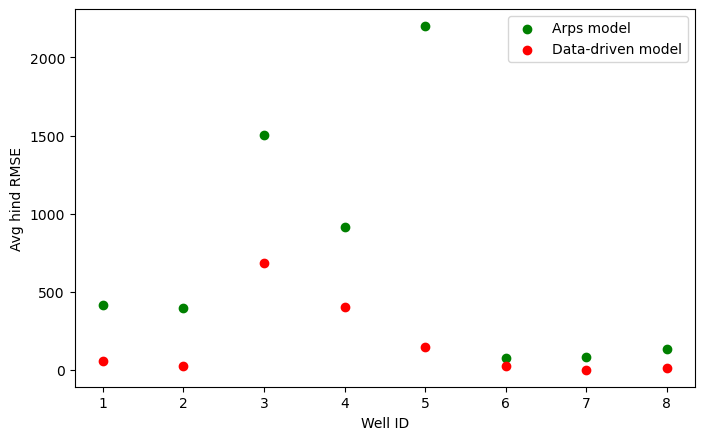

In [86]:
phase='OIL' ## try other phases here

plt.figure(figsize=[8,5])
x=np.unique(df_rmse_8['Well ID'])
y1=df_arps_8['Average_hind_rmse'].loc[df_arps_8['Phase']==phase]
y2=df_rmse_8['Average_hind_rmse'].loc[df_rmse_8['Phase']==phase]
plt.scatter(x, y1, c='g')
plt.scatter(x, y2, c='r')
plt.xlabel('Well ID')
plt.ylabel('Avg hind RMSE')
plt.legend(['Arps model', 'Data-driven model'], loc='upper right')

## prediction for last 4 wells

#### Repeating the above process for the last 4 wells with daily production. The daily production of the last month is predicted 

In [65]:
def get_history(wid, n_days, phase):
    data=df_prod[['DAYS','%s'%phase]].loc[df_prod['Well ID']==wid]
    data.reset_index(drop=True, inplace=True)
    hist=(df_prod['%s'%phase].loc[df_prod['Well ID']==wid]).shift(1, axis=0).values
    data['%s_hist'%phase]=hist
    data.dropna(inplace=True)
    #print(data)
    train, test= data.iloc[:n_days-1,:], data.iloc[n_days-1:n_days+30,:]
    return train, test

In [12]:
train, test= get_history(wid=10, n_days=5*30, phase='OIL')

In [102]:
## this cell takes time to run

well=[]
fluid_phase=[]
hind_rmse=[]

month=30
for n_days in [5*month,11*month,17*month]:
    error=[]
    for wid in range (9,13):
        for phase in ['OIL', 'GAS', 'WATER']:
            well.append(wid)
            fluid_phase.append(phase)
            train, test=get_history(wid=wid,n_days=n_days,phase=phase)
            trainx=train.values[:,2].reshape(len(train), 1)
            trainy=train.values[:,2].reshape(len(train), 1)
            testx=test.values[:,2].reshape(len(test), 1)
            testy=test.values[:,2].reshape(len(test), 1)
            rf=RandomForestRegressor(n_estimators=1000)
            rf.fit(trainx, trainy)
            yhat=rf.predict(testx)
            rmse=np.sqrt(np.mean((testy - yhat) ** 2))
            error.append(rmse)   
    hind_rmse.append(error)
            

In [103]:
df_rmse=pd.DataFrame()
df_rmse['Well ID']=well[0:12]
df_rmse['Phase']=fluid_phase[0:12]
df_rmse['hind_6_months_rmse']=hind_rmse[0]
df_rmse['hind_12_months_rmse']=hind_rmse[1]
df_rmse['hind_18_months_rmse']=hind_rmse[2]
df_rmse.head()

,Well ID,Phase,hind_6_months_rmse,hind_12_months_rmse,hind_18_months_rmse
0,9,OIL,52.077947,20.833908,10.440417
1,9,GAS,669.581906,162.111506,136.626461
2,9,WATER,79.794458,20.014697,23.336385
3,10,OIL,19.733429,20.137419,2.273938
4,10,GAS,312.857695,337.119105,89.783120


In [109]:
df_rmse['Average_hind_rmse'] = df_rmse.iloc[:, 2:].mean(axis=1) ##getting avg rmse
df_rmse.head()

,Well ID,Phase,hind_6_months_rmse,hind_12_months_rmse,hind_18_months_rmse,Average_hind_rmse
0,9,OIL,52.077947,20.833908,10.440417,27.784091
1,9,GAS,669.581906,162.111506,136.626461,322.773291
2,9,WATER,79.794458,20.014697,23.336385,41.048513
3,10,OIL,19.733429,20.137419,2.273938,14.048262
4,10,GAS,312.857695,337.119105,89.783120,246.586640


In [105]:
df_rmse.to_pickle('rmse_4_wells.p') ##saving the result for 4 wells 

In [106]:
df_rmse_4=pd.read_pickle('rmse_4_wells.p')
df_arps_4=df_arps.loc[df_arps['Well ID']>=9]

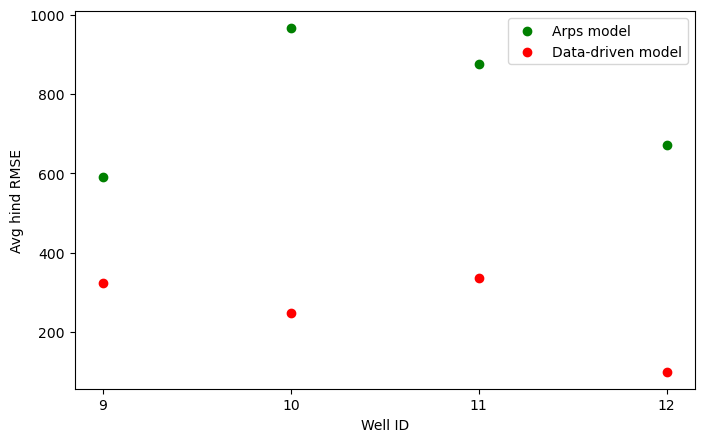

In [110]:
phase='GAS' ## test other phases here

plt.figure(figsize=[8,5])
x=np.unique(df_rmse_4['Well ID'])
y1=df_arps_4['Average_hind_rmse'].loc[df_arps_4['Phase']==phase]
y2=df_rmse_4['Average_hind_rmse'].loc[df_rmse_4['Phase']==phase]
plt.scatter(x, y1, c='g')
plt.scatter(x, y2, c='r')
plt.xlabel('Well ID')
plt.xticks(np.arange(9,13,step=1))
plt.ylabel('Avg hind RMSE')
plt.legend(['Arps model', 'Data-driven model'], loc='upper right')

In [16]:
## demo of well 10 oil phase using Random Forest

phase ='OIL'

def show_fit(t, q, yhat,wid):
    plt.figure(figsize=[6,4])
    if phase == 'OIL':
        color = 'g'
    elif phase == 'GAS':
        color = 'r'
    elif phase == 'WATER':
        color = 'b'
    plt.plot(t, q, color=color, linestyle='dotted')
    plt.plot(t, yhat, color=color, linestyle='solid')
    plt.xlabel('Time (Days)')
    plt.ylabel('Rates')
    plt.title('well_%s'%wid)
    plt.show()

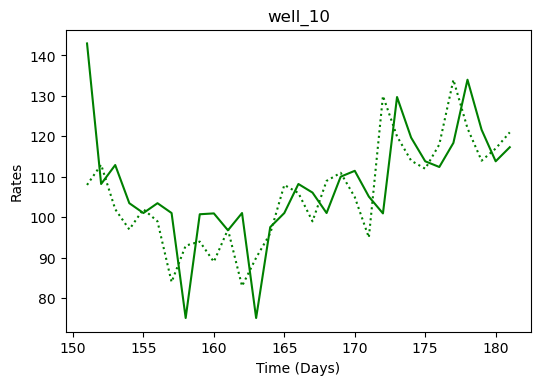

In [17]:
show_fit(t, q, yhat, 10)